## Bayesian Optimisation Verification

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
from scipy import interpolate
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from scipy import stats
from scipy.stats import norm
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import cdist
from scipy.optimize import fsolve
import math

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Trial on TiOx/SiOx
Tempeature vs. S10_HF

In [2]:
#import timestamp from data sheet (time:0~5000s) 
address = 'data/degradation.xlsx'
df = pd.read_excel(address,sheet_name = 'normal data',usecols = [0],names = None,nrows = 5000)
df_time = df.values.tolist()

In [3]:
#import data sheet at 85 C (time:0~5000s) 

df = pd.read_excel(address,sheet_name = 'normal data',usecols = [3],names = None,nrows = 5000)
df_85 = df.values.tolist() 
df = pd.read_excel(address,sheet_name = 'smooth data',usecols = [3],names = None,nrows = 5000)
df_85s = df.values.tolist()

In [4]:
# Format date into numpy array format
x_normal = np.array(df_time).T
y_normal = np.array(df_85).T 
x_normal = x_normal.reshape((5000))
y_normal = y_normal.reshape((5000))

x_7_5000 = np.array([0,99,999,1999,2999,3999,4999])

In [6]:
# Find the minimum value in the bound
# 5000 * 5000
# Find minimum value in the last row as the minimum value for the bound

def ucb(X , gp, dim, delta):
        """
        Calculates the GP-UCB acquisition function values
        Inputs: gp: The Gaussian process, also contains all data
        x:The point at which to evaluate the acquisition function 
        Output: acq_value: The value of the aquisition function at point x
        """
        mean, var = gp.predict(X[:, np.newaxis], return_cov=True)
        mean = np.atleast_2d(mean).T
        var = np.atleast_2d(var).T  
        beta = 2*np.log(np.power(5000,2.1)*np.square(math.pi)/(3*delta))
        return mean - np.sqrt(beta)* np.sqrt(np.diag(var))


In [62]:
def ucb_plot(X,Y,X_, y_mean,ucb_y_min):
    plt.figure()
    plt.plot(X_, y_mean, 'k', lw=1, zorder=9)
    plt.fill_between(X_, y_mean, ucb_y_min,alpha=0.5, color='k')
    plt.scatter(X, Y, c='r', s=10, zorder=10)
    # plot the minimum point from ucb lower bound
    # plt.scatter(np.argmin(ucb_y_min),min(ucb_y_min),c='g', s=50)
    plt.tick_params(axis='y', colors = 'white')
    plt.tick_params(axis='x', colors = 'white')
    plt.ylabel('Lifetime',color = 'white')
    plt.xlabel('Time',color = 'white')
    plt.title('UCB')
    plt.xlim(0,4900)
    plt.ylim(0.7,0.8)
    plt.tight_layout()
    plt.show()

In [63]:
def plot (X,X_,y_mean,y,y_cov):
    #plot function
    plt.figure()
    plt.plot(X_, y_mean, 'k', lw=1, zorder=9)
    plt.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),y_mean + np.sqrt(np.diag(y_cov)),alpha=0.5, color='k')
    plt.scatter(X[:, 0], y, c='r', s=10, zorder=10)
    plt.tick_params(axis='y', colors = 'white')
    plt.tick_params(axis='x', colors = 'white')
    plt.ylabel('Lifetime',color = 'white')
    plt.xlabel('Time',color = 'white')
    plt.title('Original')
    plt.xlim(0,4900)
    plt.ylim(0.7,0.8)
    plt.tight_layout()
    plt.show()

Length scale bound max = 10


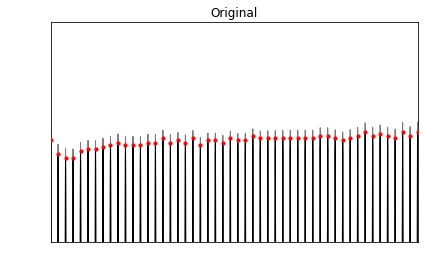

Length scale bound max = 20


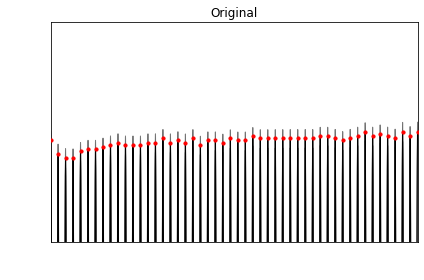

Length scale bound max = 50


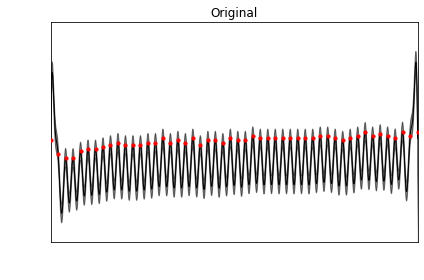

Length scale bound max = 100


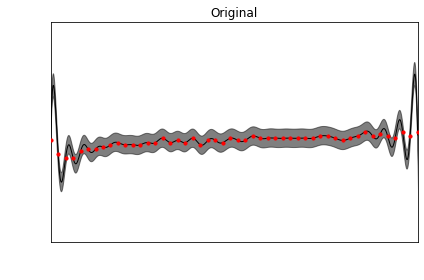

Length scale bound max = 200


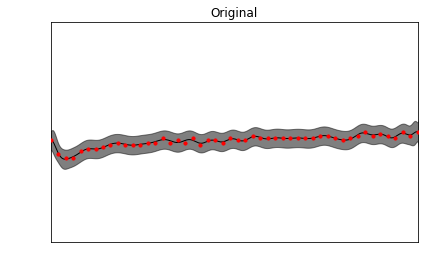

Length scale bound max = 400


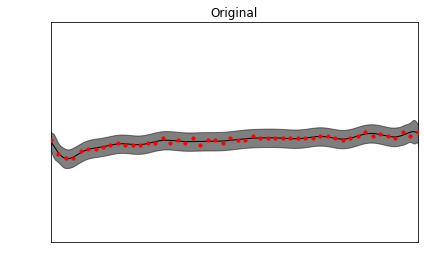

Length scale bound max = 500


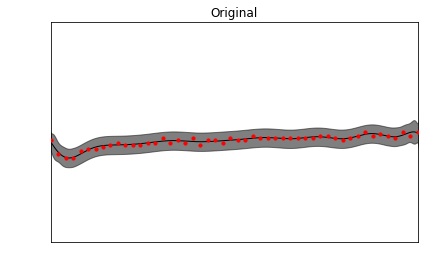

Length scale bound max = 700


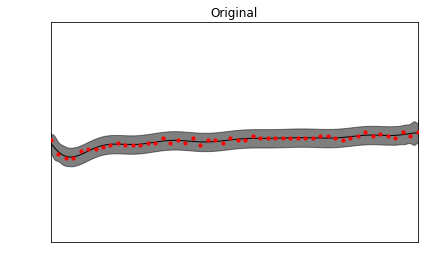

Length scale bound max = 1000


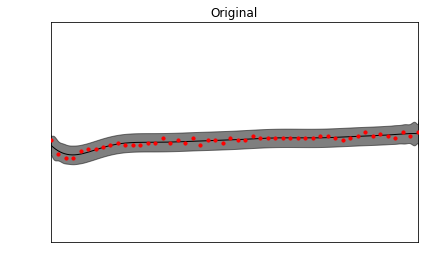

Length scale bound max = 1500


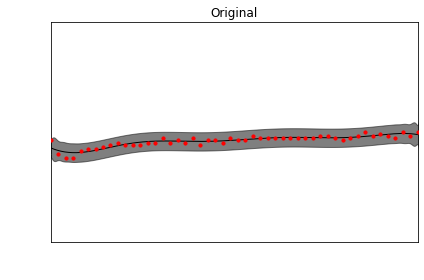

Length scale bound max = 2000


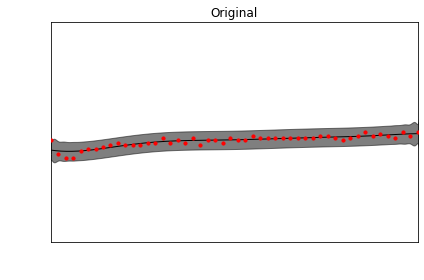

In [64]:
# Preparing training set from a few data points
# 
x_loop = np.arange(0,5000,100)
X = x_normal[x_loop].reshape(x_loop.size)
Y = y_normal[x_loop]
X = X.reshape(x_loop.size,1)

X_ = np.linspace(0,5000, 5000)

# Kernel setting
length_scale_bounds_MAX = None
length_scale_bounds_MIN = 1e-4

for length_scale_bounds_MAX in (10,20,50,100,200,400,500,700,1000,1500,2000):
    kernel = 1.0 * RBF(length_scale=20,length_scale_bounds=(length_scale_bounds_MIN, length_scale_bounds_MAX)) + WhiteKernel(noise_level=0.0001)
    gp = GaussianProcessRegressor(kernel=kernel,alpha=0.0).fit(X, Y)
    y_mean = gp.predict(X_[:, np.newaxis])
    acp_value = ucb(X_, gp, 0.1, 5)
    ucb_y_min = acp_value[-1]
    print('Length scale bound max =',length_scale_bounds_MAX)
    # ,'\nStandard plot')
    plot (X,X_,y_mean,y,y_cov)
    # print('UCB plot')
    # ucb_plot(X,Y,X_, y_mean,ucb_y_min)

Number of data points used: 5000
Length scale bound max = 500 
Standard plot


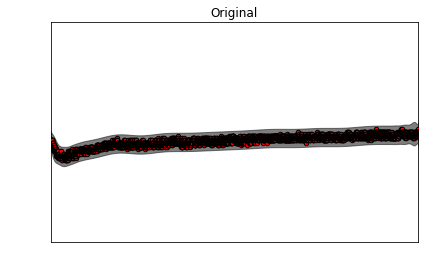

UCB plot


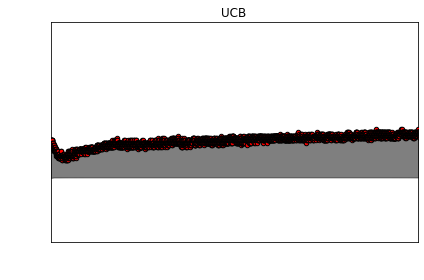

In [61]:
# Preparing training set from a few data points
# 
x_loop = np.arange(0,5000,1)
X = x_normal[x_loop].reshape(x_loop.size)
Y = y_normal[x_loop]
X = X.reshape(x_loop.size,1)

X_ = np.linspace(0,5000, 5000)

# Kernel setting
length_scale_bounds_MAX = 500
length_scale_bounds_MIN = 1e-4

# for length_scale_bounds_MAX in (10,20,50,100,200,400,500,700,1000,1500,2000):

kernel = 1.0 * RBF(length_scale=20,length_scale_bounds=(length_scale_bounds_MIN, length_scale_bounds_MAX)) + WhiteKernel(noise_level=0.00000001)
gp = GaussianProcessRegressor(kernel=kernel,alpha=0.0).fit(X, Y)
y_mean = gp.predict(X_[:, np.newaxis])
acp_value = ucb(X_, gp, 0.1, 5)
ucb_y_min = acp_value[-1]
print('Number of data points used:', x_loop.size)
print('Length scale bound max =',length_scale_bounds_MAX,'\nStandard plot')
plot (X,X_,y_mean,Y,y_cov)
print('UCB plot')
ucb_plot(X,Y,X_, y_mean,ucb_y_min)